In [2]:
%matplotlib inline
import ipywidgets
import numpy as np, pylab as plt, aipy, capo, omnical
import capo.hex
aa = aipy.cal.get_aa('hsa7458_v001', np.array([.15]))
capo.hex.aa_to_info_hera(aa)
info = capo.hex.aa_to_info_hera(aa)
reds = info.get_reds()
def get_red(sep):
     for r in reds:
          if sep in r: return r

x


/Users/jsdillon/anaconda/lib/python2.7/site-packages/capo/hex.py:82: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  antpos[i,0], antpos[i,1], antpos[i,2] = x,y,z


# Load Omnical Output and Flag RFI

In [3]:
fm,fg,fv,fx = capo.omni.from_npz('zen.2457678.39660.yy.HH.uvc.fc.npz')
m,g,v,x = capo.omni.from_npz('zen.2457678.39660.yy.npz')
POL = 'yy'
ALL_ANTS = g[POL[0]].keys()
NTIMES,NCHAN = g[POL[0]][ALL_ANTS[0]].shape
print ALL_ANTS
ANTS = [88,9,20,89,43]
rfi = capo.xrfi.omni_chisq_to_flags(m['chisq'])
capo.plot.waterfall(rfi, drng=1)
plt.show()

IOError: [Errno 2] No such file or directory: 'zen.2457678.39660.yy.npz'

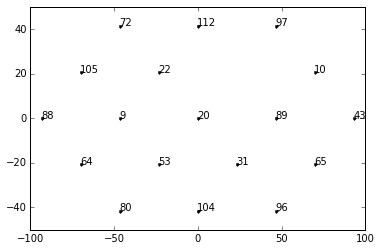

In [3]:
for ai in ALL_ANTS:
    plt.plot(aa[ai].pos[1], aa[ai].pos[0], 'k.')
    plt.text(aa[ai].pos[1], aa[ai].pos[0], str(ai))
plt.show()

In [4]:
bls = []
for bl in [(88,i) for i in ANTS[1:-1]]:
    red = get_red(bl)
    if red is None: red = get_red(bl[::-1])
    assert(red is not None)
    for ubl in v[POL]:
        if ubl in red:
            bls.append(ubl)
            print bl, '->', ubl
            break
    if not bls[-1] == ubl: raise RuntimeError('Missing ubl for %s' % str(bl))
print bls

(88, 9) -> (9, 88)
(88, 20) -> (10, 22)
(88, 89) -> (10, 105)
[(9, 88), (10, 22), (10, 105)]


# Project Out Degeneracies that Omnical Didn't

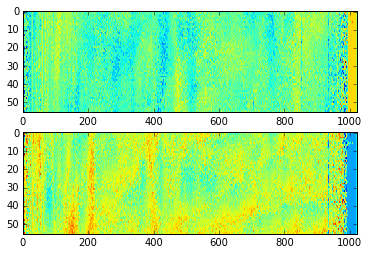

In [5]:
phsgrad = np.empty((NTIMES,3,NCHAN), np.float)
for t in xrange(NTIMES):
    gdata = np.angle([g[POL[0]][i][t]/fg[POL[0]][i].flatten() for i in ALL_ANTS])
    d,w = {}, {}
    for i,ai in enumerate(ALL_ANTS):
        d['%f*dphsdx+%f*dphsdy+%f*dphsdz' % tuple(aa[ai].pos)] = gdata[i]
        w['%f*dphsdx+%f*dphsdy+%f*dphsdz' % tuple(aa[ai].pos)] = 1.
    ls = capo.linsolve.LinearSolver(d,w)
    sols = ls.solve()
    phsgrad[t] = np.array([sols['dphsdx'], sols['dphsdy'], sols['dphsdz']])
plt.subplot(211); capo.plot.waterfall(phsgrad[:,0], mode='real')
plt.subplot(212); capo.plot.waterfall(phsgrad[:,1], mode='real')
#plt.subplot(313); capo.plot.waterfall(phsgrad[2], mode='real')
plt.show()

## Check effect on gain solutions

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


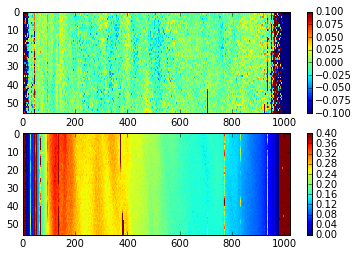

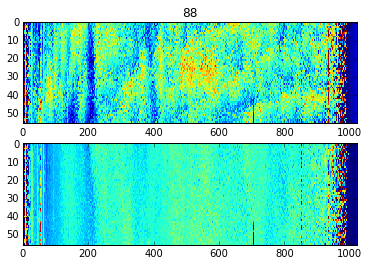

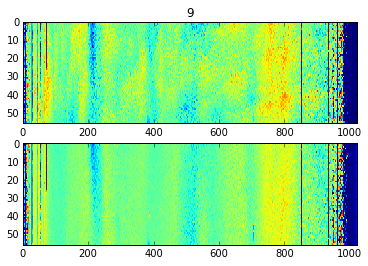

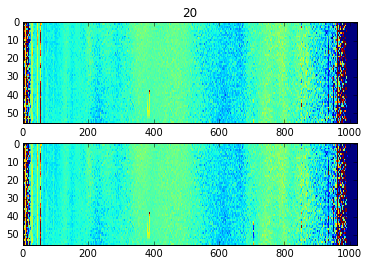

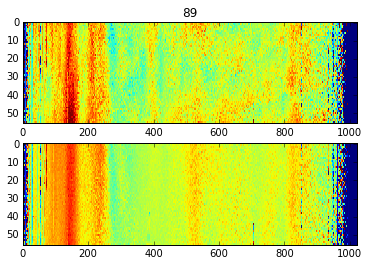

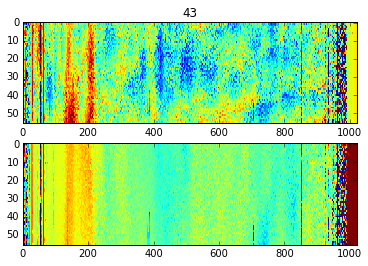

In [6]:
pg = {POL[0]:{}}
apg = {POL[0]:{}}
for i in ALL_ANTS: pg[POL[0]][i] = g[POL[0]][i] / np.exp(1j*np.dot(aa[i].pos, phsgrad))
avgphs = np.average([np.angle(pg[POL[0]][i]/fg[POL[0]][i].flatten()) for i in ALL_ANTS], axis=0)
avgamp = np.average([np.abs(pg[POL[0]][i]/fg[POL[0]][i].flatten()) for i in ALL_ANTS], axis=0)
for i in ALL_ANTS: apg[POL[0]][i] = pg[POL[0]][i] / np.exp(1j*avgphs) / avgamp
plt.subplot(211); capo.plot.waterfall(avgphs, mode='real', mx=.1, drng=.2); plt.colorbar()
plt.subplot(212); capo.plot.waterfall(avgamp, mode='real', mx=.4, drng=.4); plt.colorbar()
plt.show()
    
for i in ANTS:
    gi = g[POL[0]][i] / fg[POL[0]][i].flatten()
    pgi = pg[POL[0]][i] / fg[POL[0]][i].flatten()
    apgi = apg[POL[0]][i] / fg[POL[0]][i].flatten()
    plt.subplot(211); capo.plot.waterfall(gi, mode='phs', mx=1, drng=2)
    plt.title(str(i))
    #plt.subplot(312); capo.plot.waterfall(pgi, mode='phs', mx=1, drng=2)
    plt.subplot(212); capo.plot.waterfall(apgi, mode='phs', mx=1, drng=2)
    plt.show()

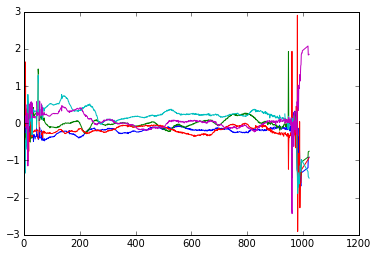

In [14]:
wgt = np.logical_not(rfi)
for i in ANTS:
    apgi = apg[POL[0]][i] / fg[POL[0]][i].flatten()
    gi_avg = np.sum(apgi*wgt, axis=0) / np.sum(wgt, axis=0)  
    plt.plot(np.angle(gi_avg), label=str(i))
#plt.ylim(.5,1.5)
plt.show()

## Check effect on model visibilities

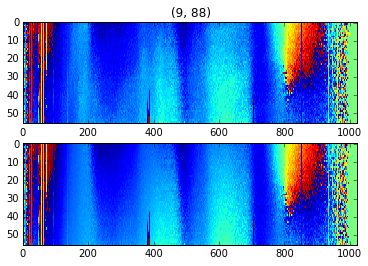

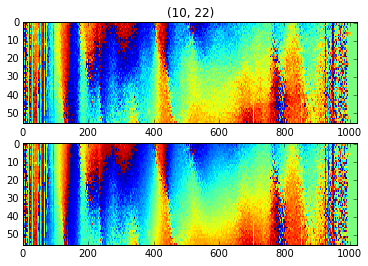

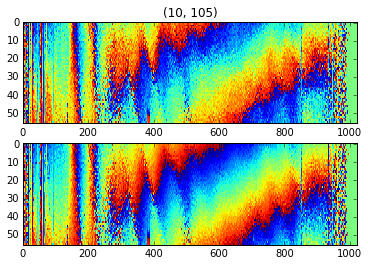

In [8]:
apv = {POL:{}}
for bl in v[POL]:
    ai,aj = bl
    dphs = np.dot(aa[ai].pos-aa[aj].pos, phsgrad)
    apv[POL][bl] = v[POL][bl] * np.exp(1j*dphs) * avgamp**2
for bl in bls:
    plt.subplot(211); capo.plot.waterfall(v[POL][bl], mode='phs')
    plt.title(bl)
    plt.subplot(212); capo.plot.waterfall(apv[POL][bl], mode='phs')
    plt.show()

# Examine Frequency Redundancy Agreement for Multiple Baselines

If there are one overall amplitude and two overall phase ramps that are unsolved for each frequency channel (and time), then we should be able to compare baselines that have the same length ratio and orientation to relate the degeneracies at different frequencies to one another.  Since there is probably a 2D phase ramp difference between 2 frequencies, I suspect there should be at most 2 independent phase parameters among the 3 baseline/freq ratios.  The analysis below seems to show that I can't use 2 of them to predict the third, which is something I don't understand.

(10, 22) (10, 105) 0.666666666667 512 0


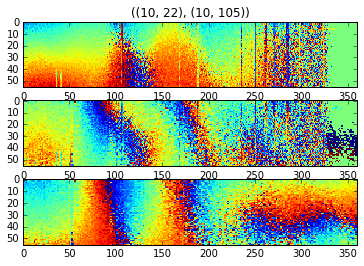

(53, 105) (31, 72) 0.666666666667 512 0


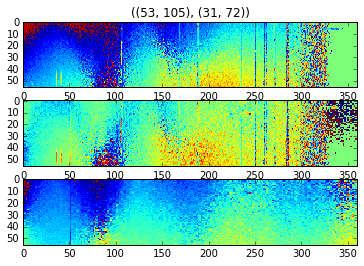

(9, 112) (104, 10) 0.666666666667 512 0


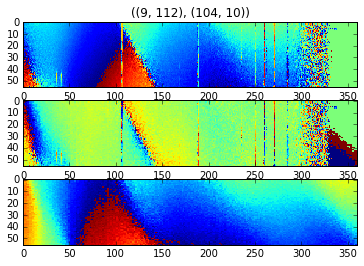

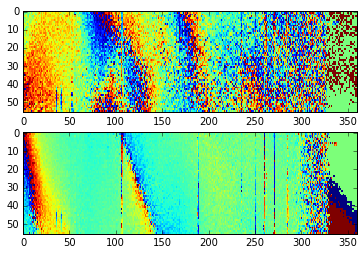

In [9]:
fq = np.linspace(.1,.2,NCHAN)
sdf = fq[1] - fq[0]
blpairs = [((10,22),(10,105)),((53,105),(31,72)),((9,112),(104,10))]
sols = {}
for bl1,bl2 in blpairs:
    d1 = aa[bl1[0]].pos - aa[bl1[1]].pos
    d2 = aa[bl2[0]].pos - aa[bl2[1]].pos
    #r = np.sqrt(np.dot(d1,d1)) / np.sqrt(np.dot(d2,d2))
    r = 2. / 3
    try: apv1 = apv[POL][bl1]
    except(KeyError): apv1 = apv[POL][bl1[::-1]].conj()
    try: apv2 = apv[POL][bl2]
    except(KeyError): apv2 = apv[POL][bl2[::-1]].conj()
    chs = np.array([np.around((f1*r - fq[0])/sdf).astype(np.int) for f1 in fq])
    valid = np.where(chs > 100, 1, 0)
    print bl1, bl2, r, 512, chs[512]
    #plt.plot(np.abs(np.average(apv1/apv2[:,chs],axis=0)))
    ch1s = np.arange(NCHAN).compress(valid)
    ch2s = chs.compress(valid)
    MODE = 'phs'
    plt.subplot(311); capo.plot.waterfall(apv1[:,ch1s], mode=MODE)
    plt.title((bl1,bl2))
    plt.subplot(312); capo.plot.waterfall(apv1[:,ch1s] / apv2[:,ch2s], mode=MODE)
    plt.subplot(313); capo.plot.waterfall(apv2[:,ch2s], mode=MODE)
    sols[bl1] = apv1[:,ch1s] / apv2[:,ch2s]
#plt.ylim(-.5,.5)
    plt.show()
    
plt.subplot(211); capo.plot.waterfall(sols[(10,22)] * sols[(53,105)].conj(), mode=MODE)
plt.subplot(212); capo.plot.waterfall(sols[(9,112)].conj(), mode=MODE)
plt.show()

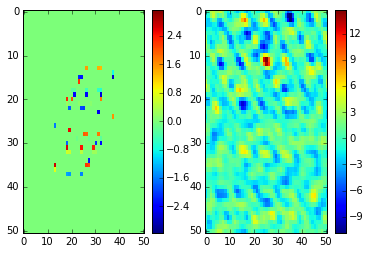

<function __main__.plt_img>

In [10]:
DIM = 51
grd = np.zeros((DIM,DIM), dtype=np.complex)
ant2px = {96:(2,-2), 64:(-1,-1), 65:(2,-1), 97:(0,2), 104:(1,-2), 9:(-1,0), 10:(1,1), 43:(2,0), 112:(-1,2), 80:(0,-2), 72:(-2,2), 20:(0,0), 53:(0,-1), 22:(-1,1), 105:(-2,1), 88:(-2,0), 89:(1,0), 31:(1,-1), 81:(0,1)}

def plt_img(t,ch):
    for (ai,aj) in apv[POL]:
        uij,vij = 5*np.array(ant2px[ai]) - np.array(ant2px[aj])
        grd[uij,vij] = apv[POL][(ai,aj)][t,ch]
        grd[-uij,-vij] = apv[POL][(ai,aj)][t,ch].conj()
    plt.subplot(121); capo.plot.waterfall(np.fft.fftshift(grd), mode='phs', mx=np.pi, drng=2*np.pi)
    plt.colorbar()
    plt.subplot(122); capo.plot.waterfall(np.fft.fftshift(np.fft.fft2(grd)), mode='real')#, mx=1, drng=2)
    plt.colorbar()
    plt.show()

ipywidgets.interact(plt_img, t=(0,NTIMES-1), ch=(0,NCHAN-1))

## Try again to solve freq redundancy, this time using longest baselines from UV file

[(31, 72), (53, 97), (72, 96), (80, 97), (9, 43), (43, 88)]


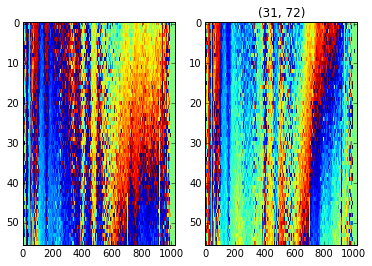

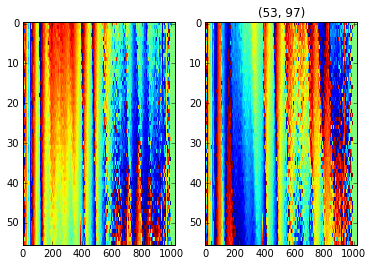

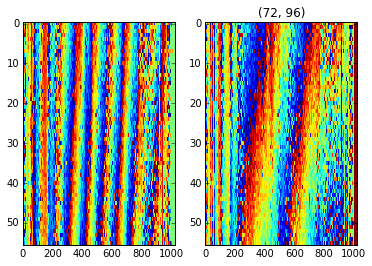

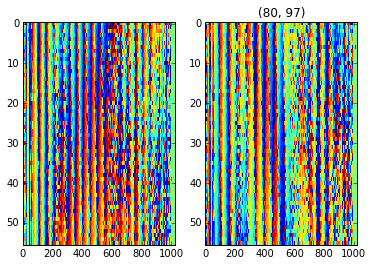

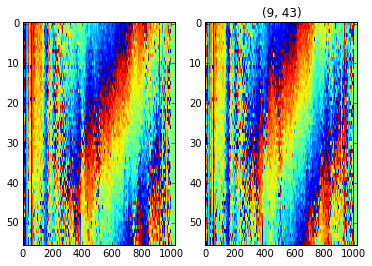

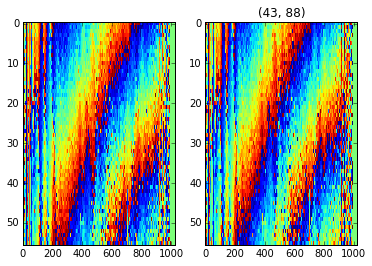

In [11]:
info,data,flgs = capo.miriad.read_files(['zen.2457678.39660.yy.HH.uvc'], antstr='43_88,9_43,80_97,53_97,72_96,31_72', polstr='yy')
print data.keys()
for bl in data:
    ai,aj = bl
    plt.subplot(121); capo.plot.waterfall(data[bl][POL], mode='phs')
    data[bl][POL] /= apg[POL[0]][ai] * apg[POL[1]][aj].conj()
    plt.subplot(122); capo.plot.waterfall(data[bl][POL], mode='phs')
    plt.title(bl)
    plt.show()

(9, 43) (88, 43) 0.75 512 128


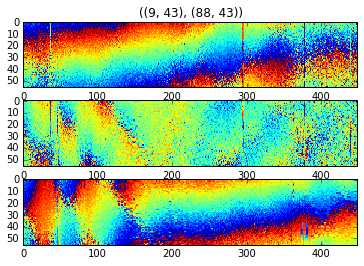

(53, 97) (80, 97) 0.75 512 128


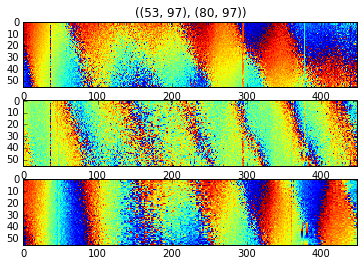

(72, 31) (72, 96) 0.75 512 128


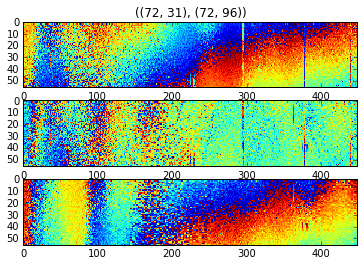

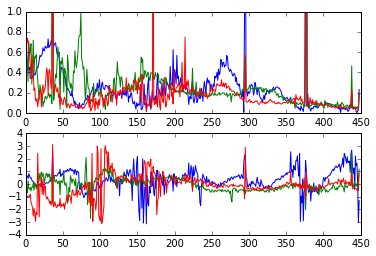

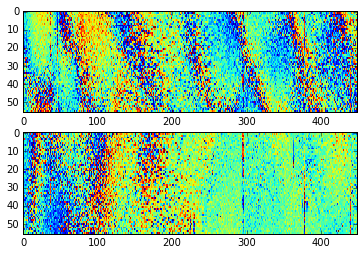

In [12]:
fq = np.linspace(.1,.2,NCHAN)
sdf = fq[1] - fq[0]
blpairs = [((9,43),(88,43)), ((53,97),(80,97)), ((72,31),(72,96))]
sols = {}
for bl1,bl2 in blpairs:
    d1 = aa[bl1[0]].pos - aa[bl1[1]].pos
    d2 = aa[bl2[0]].pos - aa[bl2[1]].pos
    #r = np.sqrt(np.dot(d1,d1)) / np.sqrt(np.dot(d2,d2))
    r = .75
    try: apv1 = data[bl1][POL]
    except(KeyError): apv1 = data[bl1[::-1]][POL].conj()
    try: apv2 = data[bl2][POL]
    except(KeyError): apv2 = data[bl2[::-1]][POL].conj()
    chs = np.array([np.around((f1*r - fq[0])/sdf).astype(np.int) for f1 in fq[:-100]])
    valid = np.where(chs > 100, 1, 0)
    print bl1, bl2, r, 512, chs[512]
    #plt.plot(np.abs(np.average(apv1/apv2[:,chs],axis=0)))
    ch1s = np.arange(NCHAN).compress(valid)
    ch2s = chs.compress(valid)
    MODE,MX,DRNG = 'log',0,2
    MODE,MX,DRNG = 'phs',np.pi,2*np.pi
    plt.subplot(311); capo.plot.waterfall(apv1[:,ch1s], mode=MODE, mx=MX, drng=DRNG)
    plt.title((bl1,bl2))
    plt.subplot(312); capo.plot.waterfall(apv1[:,ch1s] / apv2[:,ch2s], mode=MODE, mx=MX, drng=DRNG)
    plt.subplot(313); capo.plot.waterfall(apv2[:,ch2s], mode=MODE, mx=MX, drng=DRNG)
    sols[bl1] = apv1[:,ch1s] / apv2[:,ch2s]
#plt.ylim(-.5,.5)
    plt.show()

for bl in sols:
    plt.subplot(211); plt.plot(np.abs(np.average(sols[bl], axis=0)))
    plt.subplot(212); plt.plot(np.angle(np.average(sols[bl], axis=0)))
plt.subplot(211); plt.ylim(0,1)
plt.show()
    
plt.subplot(211); capo.plot.waterfall(sols[(9,43)] * sols[(53,97)].conj(), mode=MODE, mx=MX, drng=DRNG)
plt.subplot(212); capo.plot.waterfall(sols[(72,31)], mode=MODE, mx=MX, drng=DRNG)
plt.show()